## Applying various techniques to detect clusters in ecommerce transactions

This notebook contains code applying different type of unsupervised learning techbuques and LDA to a field containing product description. 

The data are obtained from the following challenge in Kaggle, containing purchase transactions from customers: https://www.kaggle.com/carrie1/ecommerce-data

The code provides answers to the below questions, focusing on Question 1: 

1 - Find the 'behaviour' groups / clusters (Hint: you can use the purchase behaviour for that)
2 – Explain, if possible, what clusters you have found (for example, customers purchasing furniture, purchasing jewellery, etc.)
3- How you can use the clusters from the given dataset to make actionable business insights and what will these insights be?



#### Pre-processing  

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv', encoding = 'ISO-8859-1')

In [3]:
# Type of columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
data.shape

(541909, 8)

In [6]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
#data['InvoiceNo'] = pd.to_numeric(data['InvoiceNo']) apparently not numeric

It seems that the InvoiceNo and StockCode used jointly are the unique identifiers of each transaction.

In [7]:
# Check for duplicates, sorting by InvoiceNo and StockCode
df = data.sort_values(['InvoiceNo', 'StockCode']).drop_duplicates()
df.shape

(536641, 8)

In [8]:
# Check for NAs
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

I will drop transactions with no Description since I will use description for unsupervised learning.

In [9]:
df = df.dropna(subset=['Description'])
df.shape

(535187, 8)

In [10]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133583
Country             0
dtype: int64

In [11]:
# CustomerID can be dropped as a column as I will not do much with it
df = df.drop('CustomerID', axis=1)

### Preprocess the description field 

We have a description field, which is a text field. Since it consists of realtively longer text, we might want to use other methods to pre-process it rather than just splitting it to categories or creating one-hot encoding.

One approach is to split each transaction description in individuals words (also called tokens). I will use sklearn's CountVectorizer to build a bag-of-words of the descriptions. Then I will apply k-means clustering, find the optimal number of clusters and extract the most frequent words per cluster. 

The second approach uses nltk to split each description in a list of tokens. We can also filter out digits and leave only letters, for example. We can retain only nouns because nouns are more likely to represent a type of a product. This selection only on nouns can be applied to the first approach as well. 

#### Approach 1: Create tokens using bag-of-words 

The first approach we implement is using one of sklearn's built in functions and it transforms the text using a bag-of-words approach. A bag-of-words splits each description in individual tokens and creates a count for how often a token occurs in a given description (also called document). We can also choose to retain only words and ignore digits and special characters, remove stop-words (words such as 'and, the, a, an, etc..'). 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

vect = CountVectorizer(stop_words=ENGLISH_STOP_WORDS,max_features=100, token_pattern=r'(?u)\b[^\W\d][^\W\d]+\b').fit(df.Description)
X = vect.transform(df.Description)

df_desc = pd.DataFrame(X.toarray(), columns = vect.get_feature_names())

In [13]:
df_desc.head()

,antique,assorted,bag,bird,birthday,black,blue,bottle,bowl,box,...,vintage,wall,water,white,wicker,wood,wooden,woodland,wrap,zinc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
# merge the dataset of BOWs with the rest of the ecommerce data

df_no_desc = df.drop('Description', axis=1)
con = np.concatenate([df_no_desc, df_desc], axis = 1)
data_column_names = list(df_no_desc.columns) + list(df_desc.columns)
df_merged = pd.DataFrame(con, columns=data_column_names)
df_merged.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,antique,assorted,bag,bird,...,vintage,wall,water,white,wicker,wood,wooden,woodland,wrap,zinc
0,536365,21730,6,2010-12-01 08:26:00,4.25,United Kingdom,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,536365,22752,2,2010-12-01 08:26:00,7.65,United Kingdom,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,536365,71053,6,2010-12-01 08:26:00,3.39,United Kingdom,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,536365,84029E,6,2010-12-01 08:26:00,3.39,United Kingdom,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,536365,84029G,6,2010-12-01 08:26:00,3.39,United Kingdom,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


The dataset _df_merged_ then consists of the original columns of our ecommerce data and the description has been transformed to individual columns with a BOW approach. The BOW has split the description in individual tokens and the number in each row represents the count for that particular token in each description. The result of the BOW is a sparse matrix (storing only non-zero elements) because many of the entries will be 0's. 

In [15]:
# How many clusters are appropriate?
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_merged.iloc[:, 7:])
    inertia.append(np.sqrt(kmeans.inertia_))

Text(0,0.5,'Inertia value')

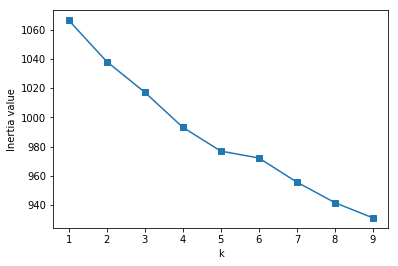

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 10), inertia, marker='s')
plt.xlabel('k')
plt.ylabel('Inertia value')

Looking at this plot, perhaps 5 clusters will be sufficient. 

In [17]:
# Can we tell something about what the 5 clusters represent? 

# First we can have a look at the most frequent words
cumulative_sum = df_merged.iloc[:, 7:].cumsum()
sums = cumulative_sum.tail(1).T 

# rename the column name
sums = sums.rename(columns={535186: 'total_sum'})
 
#create a new column for proportion 1s
sums['proportion'] = sums.total_sum / len(df_merged)
sums.sort_values('total_sum', ascending=False)

,total_sum,proportion
set,62926,0.117578
bag,51547,0.0963159
red,43080,0.0804952
heart,38856,0.0726027
retrospot,34849,0.0651156
vintage,33465,0.0625295
design,29720,0.055532
pink,29588,0.0552853
christmas,24878,0.0464847
box,24227,0.0452683


We see that among the most common tokens in the desctiptions are: **set, bag, red, heart, retrospot, vintage, design, pink, christmas, box, cake, jumbo, white, metal, blue, lunch, light, sign**. 

These words should give us some idea about most common purchases, such as bags, (perhaps gift) sets, vintage products, Christmas-related sales, cakes, etc. 

However, we'd still ideally like to say which products belong to each of the fice clusters. 

There are two ways we can do. First, we can use T-SNE to see whether we can distinguish five clusters.

Second, we can predict the cluster each transaction is assigned to and check the most common words in the clusters.

#### T-SNE model 

Trying to run to below code takes a lot of time to train, so instead I have trained a TSNE model in the background on a Hadoop cluster, pickled it and imported it here.

In [15]:
import pickle

filename = 'tsne_model.sav'
model = pickle.load(open(filename, 'rb'))

C:\Users\C49091\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator TSNE from version 0.19.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
#Import the fitted and transformed data (which is the time-consuming part)
fn = 'transformed_tsne.sav'
transformed = pickle.load(open(fn, 'rb'))

In [17]:
transformed.shape

(535187, 2)

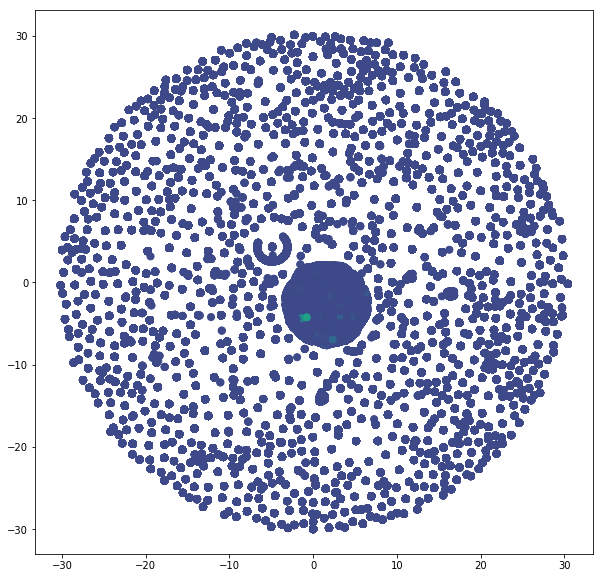

In [24]:
# Let's plot the TSNE model, here trying to color by UnitPrice (experimenting with coloring by other features did 
# nor result in any particularly interesting results)
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.figure(figsize=(10, 10))
plt.scatter(x_axis, y_axis, s=50, c=df_merged.UnitPrice)
plt.show()

The T-sne plot is a bit difficult to read given that we have hundreds of thousands of observations. There is definitely a consentration around the 0 starting point. 

Thus, T-sne is perhaps not the most informative approach, especially with such a large data set. 

Alternatively, we can predict the clusters and see which are the most frequent clusters, and then which words are in the most frequently predicted clusters.

In [18]:
# Let's predict the clusters after re-training the model with 5 clusters only

# Fit a simple KMeans algorithm 
kmeans_5 = KMeans(n_clusters=5, random_state=1).fit(df_merged.iloc[:, 7:])
predicted = kmeans_5.predict(df_merged.iloc[:, 7:])

In [19]:
np.unique(predicted, return_counts=True)

(array([0, 1, 2, 3, 4]),
 array([ 31123, 379300,  60327,  43470,  20967], dtype=int64))

In [20]:
# Merge the predicted clusters back with the rest of the data
exp = np.concatenate([df_merged, np.expand_dims(predicted, 1)], axis=1)
cols = list(df_merged) + ['predicted_cluster']

df_clusters = pd.DataFrame(exp, columns=cols)

In [21]:
# Cluster 1 is the largest, followed by cluster 2
df_clusters.predicted_cluster.value_counts()

1    379300
2     60327
3     43470
0     31123
4     20967
Name: predicted_cluster, dtype: int64

In [22]:
# Can split the dataset and explore some of the most frequent words in each cluster

cl1 = df_clusters[df_clusters.predicted_cluster==1]

cumulative_sum1 = cl1.iloc[:, 7:-1].cumsum()
sums1 = cumulative_sum1.tail(1).T 
# rename the column name
sums1 = sums1.rename(columns={535186: 'total_sum'})

sums1.sort_values('total_sum', ascending=False).head(15)

,total_sum
heart,33654
pink,22970
vintage,21191
box,21060
christmas,20679
white,18648
red,17828
light,17416
holder,15753
hanging,15748


We see, for instance, the top words in this cluster have to do with **heart, box, christmas, cake, pack, etc.**, so perhaps it captures purcahses for certain holidays (Christmas, Valentine's day, etc.). 

In [23]:
# Can split the dataset and explore some of the most frequent words in each cluster

cl2 = df_clusters[df_clusters.predicted_cluster==2]

cumulative_sum2 = cl2.iloc[:, 7:-1].cumsum()
sums2 = cumulative_sum2.tail(1).T 
# rename the column name
sums2 = sums2.rename(columns={535175: 'total_sum'})

sums2.sort_values('total_sum', ascending=False).head(15)

,total_sum
set,60470
tins,6061
pantry,5351
cake,5145
paper,4901
design,4592
vintage,4050
tea,3717
retrospot,3654
cases,3392


We see that words such as **set, tins, pantry, cake, tea, etc.** emerge. So this cluster could reflect purchases related to household items.

In [24]:
# Can split the dataset and explore some of the most frequent words in each cluster

cl3 = df_clusters[df_clusters.predicted_cluster==3]

cumulative_sum3 = cl3.iloc[:, 7:-1].cumsum()
sums3 = cumulative_sum3.tail(1).T 
# rename the column name
sums3 = sums3.rename(columns={535146: 'total_sum'})

sums3.sort_values('total_sum', ascending=False).head(15)

,total_sum
bag,42278
jumbo,17920
lunch,11990
design,9426
vintage,8224
paisley,4992
pink,4989
charlotte,4786
suki,3973
polkadot,3268


In this cluster words that pop are **bag, jumbo, lunch, design, vintage, etc.**. So perhaps this cluster captures more transactions related to accessories. 

In a similar way, we can explore what is happening in the other two clusters. We see that even such a simple approach relatively well splits up the clusters and different topics emerge in the different groups. 

If we wanted to **improve** the analysis, we could get rid of adjectives and leave only Nouns in our bag-of-words as we currently see a lot of adjectives in the top frequent words per cluster. Looking only at nouns, we could get a better understanding of the products bought by each cluster of customers.  

### Topic modellsing with LDA

We can instead split the descriptions in single tokens using nltk's functionality and apply topic modelling technique such as LDA (Latent Dirichlet Allocation). 

**LDA** models try to find groups of words that appear together frequently. Each document can be a 'mixture' of a subset of topics. A topic for a model might not be what we call a topic in everyday language but might be semantically different. 

For LDA, it's good to remove stop words, otherwise they might dominate the analysis. We can apply LDA after a BOW as well. We need to specify the number of topics in advance. We will try with 10 first, then with 5 since 5 was the number of clusters selected by a k-means approach. 

In [15]:
from sklearn.decomposition import LatentDirichletAllocation 

lda_10 = LatentDirichletAllocation(n_components=10, random_state=0, max_iter=25)
topics10 = lda_10.fit_transform(df_merged.iloc[:, 7:])

In [16]:
# Helper function to help us print topics 
def print_topics(model, n_top_words):
    words = df_merged.iloc[:, 7:].columns
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))     

In [17]:
print_topics(lda_10, 10)


Topic #0:
vintage bag jumbo cake cases paisley assorted fairy pack storage

Topic #1:
heart light hanging holder glass decoration ceramic silver drawer zinc

Topic #2:
christmas paper white wooden large heart kit frame wicker tree

Topic #3:
card pack clock tea birthday gift flower union cover green

Topic #4:
pink polkadot regency mug black green bowl skull blue white

Topic #5:
set pantry feltcraft cream tins woodland tin lights candles tea

Topic #6:
metal sign blue home small doormat party french bunting heart

Topic #7:
red retrospot box love wall wood garden lunch small cutlery

Topic #8:
bottle hot water rose ivory childrens cup egg bird heart

Topic #9:
bag design lunch spaceboy dolly girl charlotte wrap hearts box


In [18]:
lda_5 = LatentDirichletAllocation(n_components=5, random_state=0, max_iter=25)
topics5 = lda_5.fit(df_merged.iloc[:, 7:])

In [19]:
print_topics(lda_5, 10)


Topic #0:
vintage jumbo metal cake bag sign cases tin paisley green

Topic #1:
heart box light hanging holder small decoration glass white home

Topic #2:
set red retrospot christmas paper wooden large rose heart wicker

Topic #3:
card tea bottle blue hot water pack cream bunting feltcraft

Topic #4:
design bag pink set lunch polkadot pantry dolly mug girl


This helps us compare the k-means clusters and the topics selected by an LDA. We see quite a few similarities, especially between the LDA model of 5 topics. 

### Getting rid of adjectives 

With both clustering and topic modelling, we saw many adjectives. However, we might want to capture only nouns. Let's select only nouns and repeat some of the analysis.
Let's work with the tokens created with the BOW approach provided by the CountVectorizer. We will filter out nouns and repeat the k-means clustering.

In [35]:
from nltk import word_tokenize, pos_tag

cols = df_desc.columns
tags = pos_tag(cols) 

In [38]:
tags[0]

('antique', 'NN')

In [39]:
nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

In [42]:
len(nouns)

68

In [43]:
nouns[:10]

['antique',
 'bird',
 'blue',
 'bottle',
 'bowl',
 'box',
 'cake',
 'candle',
 'cases',
 'charlotte']

Let's repeat the clustering with the filtered description.

In [46]:
# Filter the data set
df_filt_nouns = df_merged[nouns]

In [49]:
# Merge back with the first columns of the data frame
con = np.concatenate([df_no_desc, df_filt_nouns], axis=1)
column_names = list(df_no_desc.columns) + list(df_filt_nouns.columns)
df_nouns = pd.DataFrame(con, columns=column_names)
df_nouns.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,antique,bird,blue,bottle,...,tin,union,vintage,wall,water,wicker,wood,woodland,wrap,zinc
0,536365,21730,6,2010-12-01 08:26:00,4.25,United Kingdom,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,536365,22752,2,2010-12-01 08:26:00,7.65,United Kingdom,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,536365,71053,6,2010-12-01 08:26:00,3.39,United Kingdom,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,536365,84029E,6,2010-12-01 08:26:00,3.39,United Kingdom,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,536365,84029G,6,2010-12-01 08:26:00,3.39,United Kingdom,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0


In [50]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 10):
    kmeans2 = KMeans(n_clusters=k, random_state=1).fit(df_nouns.iloc[:, 7:])
    inertia.append(np.sqrt(kmeans2.inertia_))

Text(0,0.5,'Inertia value')

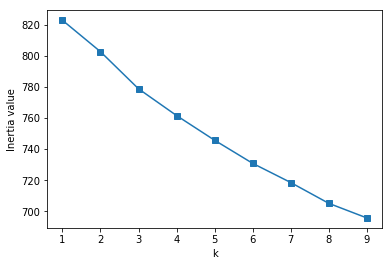

In [51]:
plt.plot(range(1, 10), inertia, marker='s')
plt.xlabel('k')
plt.ylabel('Inertia value')

Now it's less clear how many clusters there are in the data. I'd choose 2 or 3. 

In [52]:
# Fit a simple KMeans algorithm 
kmeans_2 = KMeans(n_clusters=2, random_state=1).fit(df_nouns.iloc[:, 7:])
predicted = kmeans_2.predict(df_nouns.iloc[:, 7:])

In [53]:
# Merge the predicted clusters back with the rest of the data
exp = np.concatenate([df_nouns, np.expand_dims(predicted, 1)], axis=1)
cols = list(df_nouns) + ['predicted_cluster']

df_clusters = pd.DataFrame(exp, columns=cols)

In [55]:
df_clusters.predicted_cluster.value_counts()

0    501722
1     33465
Name: predicted_cluster, dtype: int64

In [58]:
cl0 = df_clusters[df_clusters.predicted_cluster==0]

cumulative_sum0 = cl0.iloc[:, 7:-1].cumsum()
sums0 = cumulative_sum0.tail(1).T 
# rename the column name
sums0 = sums0.rename(columns={535186: 'total_sum'})

sums0.sort_values('total_sum', ascending=False).head(15)

,total_sum
heart,38626
retrospot,34777
design,28627
box,23141
metal,20972
blue,19453
cake,19361
sign,17119
lunch,16854
pack,14926


In [65]:
cl1 = df_clusters[df_clusters.predicted_cluster==1]

cumulative_sum1 = cl1.iloc[:, 7:-1].cumsum()
sums1 = cumulative_sum1.tail(1).T 
# rename the column name
sums1 = sums1.rename(columns={535152: 'total_sum'})

sums1.sort_values('total_sum', ascending=False).head(15) 

,total_sum
vintage,33465
paisley,4351
tin,2596
cake,1842
paper,1705
kit,1529
lunch,1438
union,1245
cream,1151
wrap,1094
